## Libraries

In [0]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import glob
import re

In [5]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


In [6]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [0]:
#import zipfile
#with zipfile.ZipFile("/gdrive/My Drive/Magrabia.zip", 'r') as zip_ref:
#   zip_ref.extractall("/gdrive/My Drive/Magrabia")

## Reading images

In [0]:
filenames = glob.glob('/content/gdrive/My Drive/CRP_Attali_Wu_Allouche_Bekdouche/Third Branch/Magrabia/Magrabia/MagrabiaMale/*.tif')
male_size = len(filenames)
#filenames += glob.glob('/gdrive/My Drive/Magrabia/Magrabia/MagrabiFemale/*.tif')
filenames.sort(key=lambda f: int(re.sub('\D', '', f)))
image_list = pd.DataFrame(index=[x for x in range(1,1+int(len(filenames)/7))],
                          columns=["img1","img2","img3","img4","img5","img6","prime",
                                   "cup_area_mean","cup_area_std","disc_area_mean","disc_area_std"]) 

In [0]:
len(filenames)/7

47.0

In [0]:
for filename in filenames:
    pos = [int(n) for n in re.findall(r'\d+', filename)]
    im = cv2.imread(filename)
    if 'Female' not in filename :
        if ('prime' not in filename) and (len(pos)==2):
            #print(pos,pos[0],"/",image_list.shape[0])
            image_list.iloc[pos[0]-1]["img"+str(pos[1])]= im
        else : 
            #print(pos,pos[0],"/",image_list.shape[0])
            image_list.iloc[pos[0]-1]["prime"]= im
    else :
        if ('prime' not in filename) and (len(pos)==2):
            #print(pos,int(male_size/7)+pos[0]-2,"/",image_list.shape[0])
            image_list.iloc[int(male_size/7)+pos[0]-1]["img"+str(pos[1])]= im
        else:
            #print(pos,int(male_size/7)+pos[0]-2,"/",image_list.shape[0])
            image_list.iloc[int(male_size/7)+pos[0]-1]["prime"]= im

In [0]:
image_list[["img1","img2","img3","img4","img5","img6","prime"]].isna().sum()

img1     0
img2     0
img3     0
img4     0
img5     0
img6     0
prime    0
dtype: int64

In [0]:
image_list.index

Int64Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
            18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
            35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47],
           dtype='int64')

In [0]:
img = cv2.imread('image_ex.jpg')
img2=image_list.iloc[0]["img1"]
#img3=cv2.imread('data_segmentation/BinRushed/BinRushed1/image1-1.jpg')
#imgray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # change the color of the image to black and white
#ret, thresh = cv2.threshold(imgray, 0, 255, 0)
#ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
#contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

In [0]:
def remove_noisy(contours):
    final_contours = []
    for contour in contours:
        area = cv2.contourArea(contour)
        if area > 300:                    # to remove noisy points
            final_contours.append(contour)
    return final_contours

In [0]:
def create_window(image):
    cv2.namedWindow('image',cv2.WINDOW_NORMAL)
    cv2.resizeWindow('image', 1024,722)
    cv2.imshow('image',image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [0]:
def calculate_area(final_contours):
    areas = np.zeros(len(final_contours))
    i=0
    for cont in final_contours:
        area = cv2.contourArea(cont)
        areas[i] = area
        i = i+1
    return areas

In [0]:
def im_contours(img):
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY) #color in grey
    ret, thresh = cv2.threshold(gray,1,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU) #apply the mask
    kernel = np.ones((8,8),np.uint8)
    thresh =  cv2.erode(thresh,kernel,iterations = 1) # erosion : dilate the black part of the image 
    thresh=cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel) #remove outlier points
    contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)
    final_contours=remove_noisy(contours)
    cv2.drawContours(img, final_contours, -1, (0,255,0), 3) #draw the contours
    #create_window(img)
    #plt.imshow(thresh)
    calculate_area(final_contours)
    return final_contours

In [0]:
def get_areas(img) : 
  contours = im_contours(img)
  all_areas = calculate_area(contours)
  if (len(all_areas)>3) :
    return all_areas[1],all_areas[3]
  else :
     return 0,0

In [0]:
df = pd.DataFrame(index=range(1,1+image_list.shape[0]))
discs = []
cups = []
for i in range(1,7) :
  img_key = "img"+str(i)
  disc_key = "disc_area"+str(i)
  cup_key = "cup_area"+str(i)
  discs.append(disc_key)
  cups.append(cup_key)
  df[[disc_key,cup_key]] = image_list[[img_key]].apply(lambda x : get_areas(x[img_key]), axis = 1,result_type="expand") 
df

,disc_area1,cup_area1,disc_area2,cup_area2,disc_area3,cup_area3,disc_area4,cup_area4,disc_area5,cup_area5,disc_area6,cup_area6
1,204832.0,62230.5,209950.5,76708.0,220626.0,81882.0,211331.0,73587.5,212963.0,54023.0,209911.0,15884.5
2,111583.0,28798.5,104460.0,24777.5,110226.5,30708.5,113631.5,27349.0,115790.0,12864.0,113803.0,19853.5
3,235155.0,95017.5,237445.5,99609.5,249751.0,97828.0,244281.5,96478.0,255623.0,98182.0,231030.0,81578.0
4,223103.0,93866.5,227990.0,101584.5,231326.0,102147.5,237519.0,107282.5,235027.5,106864.0,232805.5,87474.0
5,261489.0,83581.5,254903.5,98020.0,270688.5,97334.5,265505.5,110018.5,276673.5,82631.0,268919.5,67715.5
...,...,...,...,...,...,...,...,...,...,...,...,...
91,187868.0,85772.0,190065.0,75780.5,198348.0,87441.0,190289.5,88872.5,197091.0,73988.0,190912.5,76874.0
92,4161.5,537.5,4017.0,450.0,4161.5,537.5,4161.5,537.5,4161.5,537.5,4161.5,537.5
93,87655.0,18097.5,93078.5,21579.5,92096.5,22158.0,89024.5,27695.0,89345.5,15251.0,87108.0,10622.0
94,6825.5,132316.0,6825.5,137204.5,317128.0,3153.5,349.0,316.5,321803.0,3153.5,349.0,316.5


In [0]:
df.iloc[[32]][df!=0][discs].mean(axis=1)

33    67876.583333
dtype: float64

In [0]:
image_list[["disc_area_mean","cup_area_mean","disc_area_std","cup_area_std"]] = pd.concat(
    [df[discs][df[discs]!=0].mean(axis=1),
     df[cups][df[cups]!=0].mean(axis=1),
     df[discs][df[discs]!=0].std(axis=1),
     df[cups][df[cups]!=0].std(axis=1)],
     axis=1)
image_list[["disc_area_mean","cup_area_mean","disc_area_std","cup_area_std"]]

,disc_area_mean,cup_area_mean,disc_area_std,cup_area_std
1,211602.250000,60719.250000,5191.881564,24192.446839
2,111582.333333,24058.500000,3984.992342,6648.809014
3,242214.333333,94782.166667,9365.170952,6654.627928
4,231295.166667,99869.833333,5157.212277,7767.760769
5,266363.250000,89883.500000,7581.073471,14905.518726
...,...,...,...,...
91,192429.000000,81454.666667,4243.518693,6609.532371
92,4137.416667,522.916667,58.991878,35.721725
93,89718.000000,19233.833333,2393.240063,5949.153424
94,108880.000000,46076.750000,163151.237381,68723.048247


In [0]:
dataset = image_list[["prime","disc_area_mean","cup_area_mean","disc_area_std","cup_area_std"]]
image_list = None
#dataset.to_csv("/gdrive/My Drive/Magrabia/dataset.csv")

In [0]:
dataset.iloc[0]["prime"].shape

(1936, 2743, 3)

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader, random_split


import matplotlib.pyplot as plt

%matplotlib inline

In [0]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


In [0]:
#dataset = pd.read_csv("/gdrive/My Drive/Magrabia/dataset.csv")

In [0]:
images = dataset["prime"].apply(torch.from_numpy)

In [0]:
labels = dataset[["prime","disc_area_mean","cup_area_mean","disc_area_std","cup_area_std"]].apply(torch.from_numpy)

In [0]:
class Model(nn.Module):
    
    def __init__(self):
        super(Model, self).__init__()
        
        self.l1 = nn.Conv2d(3, 3, kernel_size=3, stride=1, padding=1)
        self.l2 = nn.Conv2d(3, 3, kernel_size=3, stride=1, padding=1)
        self.l3 = nn.Linear(3*1936*2743,4)
        
    def forward(self, inputs):
        outputs = F.relu(self.l1(inputs))
        outputs = F.relu(self.l2(outputs))
        #print(outputs.shape)
        outputs = outputs.reshape(outputs.size(0), -1)
        outputs = self.l3(outputs)# Use softmax as the activation function for the last layer
        
        return outputs

In [0]:
def train(num_epochs, batch_size, criterion, optimizer, model, dataset):
    train_error = []
    tmp = dataset.values
    dataset_final = torch.from_numpy(tmp)
    train_loader = DataLoader(dataset_final, batch_size, shuffle=True)
    model.train()
    for epoch in range(num_epochs):
        epoch_average_loss = 0.0
        for (images, m1,m2,s1,s2) in train_loader:
            y_pre = model(images)#.view(batch_size, -1))        
            labels = torch.tensor([m1,m2,s1,s2])
            loss = criterion(y_pre, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_average_loss += loss.item() * batch_size / len(dataset)
        train_error.append(epoch_average_loss)
        print('Epoch [{}/{}], Loss: {:.4f}'
                      .format(epoch+1, num_epochs, epoch_average_loss))
    return train_error

In [0]:
# Create the model: 
model = Model()

# Choose the hyperparameters for training: 
num_epochs = 10
batch_size = 10

# Use mean squared loss function 
criterion = nn.MSELoss()

# Use SGD optimizer with a learning rate of 0.01
# It is initialized on our model
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

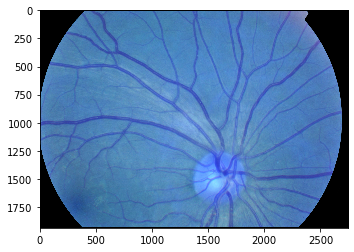

In [0]:
plt.imshow(dataset.iloc[23]["prime"])


In [0]:
train(num_epochs, batch_size, criterion, optimizer, model, dataset)

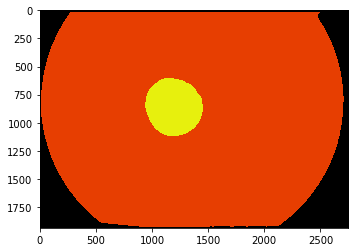

In [0]:
def create_segmented_image(img,contours):
    # creare black image to make sure that all surrounding pixels are black
    black_image = img.copy() 
    black_image[:]=(0,0,0)
    # fill the eye in red
    eye_segmented_image = cv2.fillPoly(black_image.copy(),pts=[contours[0]],color=(231, 62, 1)) 
    # fill the disc
    disc_segmented_image = cv2.fillPoly(eye_segmented_image.copy(),pts=[contours[1]],color=(231, 240, 13))
    # fill the cup
    cup_segmented_image = cv2.fillPoly(eye_segmented_image.copy(),pts=[contours[3]],color=(231, 240, 13))
    return disc_segmented_image, cup_segmented_image
contours = im_contours(img2)
disc_segmented_image, cup_segmented_image  = create_segmented_image(img2,contours)
plt.imshow(disc_segmented_image)

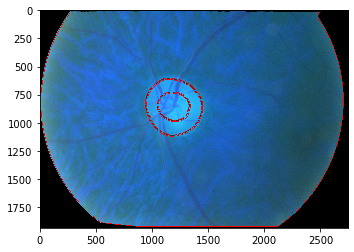

In [0]:
def check_images(img,contours): 
    #draw the contours
    cv2.drawContours(img, contours, -1, (255,0,0), 3) 
    # fill the disc
    disc_segmented_image = cv2.fillPoly(img.copy(),pts=[contours[1]],color=(231, 240, 13))
    # fill the cup
    cup_segmented_image = cv2.fillPoly(img.copy(),pts=[contours[3]],color=(231, 240, 13))
    plt.imshow(img)
    return disc_segmented_image, cup_segmented_image

disc_segmented_image, cup_segmented_image  = check_images(img2,contours)
#plt.imshow(cup_segmented_image)

In [0]:
def save_segmented_images(disc_segmented_image,cup_segmented_image,i):
    cv2.imwrite('/content/gdrive/My Drive/CRP_Attali_Wu_Allouche_Bekdouche/Third Branch/Magrabia/outputs/disc_segmented/disc_segmented_image' + str(i) + '.png',disc_segmented_image)
    cv2.imwrite('/content/gdrive/My Drive/CRP_Attali_Wu_Allouche_Bekdouche/Third Branch/Magrabia/outputs/cup_segmented/cup_segmented_image' + str(i) + '.png',cup_segmented_image)
#save_segmented_images(disc_segmented_image,cup_segmented_image,1)

In [0]:
def save_segmented_images_checked(disc_segmented_image,cup_segmented_image,i,j):
    cv2.imwrite('/content/gdrive/My Drive/CRP_Attali_Wu_Allouche_Bekdouche/Third Branch/Magrabia/outputs/disc_segmented/disc_segmented_image' + str(i) +'-' +str(j)+'.png',disc_segmented_image)
    cv2.imwrite('/content/gdrive/My Drive/CRP_Attali_Wu_Allouche_Bekdouche/Third Branch/Magrabia/outputs/cup_segmented/cup_segmented_image' + str(i) +'-' +str(j)+ '.png',cup_segmented_image)
#save_segmented_images_checked(disc_segmented_image,cup_segmented_image,1)

In [0]:
def segmented_dataset(image_list):
    i = 1
    for image_index in range(image_list.shape[0]):
        for j in range(6) : 
          image = image_list.iloc[image_index]["img"+str(j+1)]
          final_contours = im_contours(image.copy())
          try:
              
              disc_segmented_image, cup_segmented_image  = create_segmented_image(image,final_contours)
              save_segmented_images_checked(disc_segmented_image,cup_segmented_image,image_index+1,j+1)
              #print(i)
          except:
              print(image_index+1,j+1)
          i += 1

segmented_dataset(image_list)

25 1
25 2
25 3
25 4
25 5
25 6


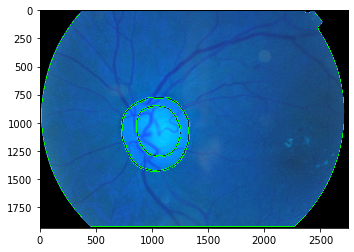

In [0]:
plt.imshow(image_list[3])